In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
n = 300
ages = np.random.normal(loc=54, scale=9, size=n).astype(int)
ages = np.clip(ages, 28, eighty := 80) 


sex = np.random.binomial(1, 0.68, size=n)

In [4]:
cp = np.random.choice([0,1,2,3], size=n, p=[0.25,0.35,0.25,0.15])
trestbps = np.random.normal(132, 18, size=n).astype(int)
trestbps = np.clip(trestbps, 90, 200)
chol = np.random.normal(246, 50, size=n).astype(int)
chol = np.clip(chol, 100, 600)
fbs = np.random.binomial(1, 0.15, size=n)
restecg = np.random.choice([0,1,2], size=n, p=[0.6,0.3,0.1])
thalach = np.random.normal(150, 22, size=n).astype(int)
thalach = np.clip(thalach, 60, 220)
exang = np.random.binomial(1, 0.33, size=n)
oldpeak = np.round(np.abs(np.random.normal(1.0, 1.0, size=n)), 2)
slope = np.random.choice([0,1,2], size=n, p=[0.25,0.5,0.25])
ca = np.random.choice([0,1,2,3,4], size=n, p=[0.6,0.2,0.12,0.06,0.02])
thal = np.random.choice([3,6,7], size=n, p=[0.55,0.2,0.25])

In [5]:
logit = (
-5.0
+ 0.03*(ages - 50)
+ 0.9*sex
+ 0.6*(cp == 3)
+ 0.02*(trestbps - 120)
+ 0.01*(chol - 200)
+ 0.8*fbs
- 0.02*(thalach - 150)
+ 1.1*exang
+ 0.6*ca
+ 0.5*(thal != 3)
)
prob = 1/(1+np.exp(-logit))
target = (np.random.rand(n) < prob).astype(int)

In [6]:
df = pd.DataFrame({
'age': ages,
'sex': sex,
'cp': cp,
'trestbps': trestbps,
'chol': chol,
'fbs': fbs,
'restecg': restecg,
'thalach': thalach,
'exang': exang,
'oldpeak': oldpeak,
'slope': slope,
'ca': ca,
'thal': thal,
'target': target
})

In [7]:
print('Dataset shape:', df.shape)
print(df.head())

Dataset shape: (300, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   58    1   1       120   222    0        0      137      1     0.46      1   
1   52    1   1       164   263    0        1      152      0     0.71      1   
2   59    0   2       144   243    0        0      153      1     0.12      2   
3   67    0   0       121   269    0        0      127      1     2.24      2   
4   51    0   1       143   249    0        0      177      1     0.84      2   

   ca  thal  target  
0   1     3       1  
1   0     6       0  
2   1     3       0  
3   0     7       0  
4   0     3       0  


In [8]:
print('\nInfo:')
print(df.info())
print('\nSummary statistics:')
print(df.describe())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       300 non-null    int64  
 1   sex       300 non-null    int32  
 2   cp        300 non-null    int64  
 3   trestbps  300 non-null    int64  
 4   chol      300 non-null    int64  
 5   fbs       300 non-null    int32  
 6   restecg   300 non-null    int64  
 7   thalach   300 non-null    int64  
 8   exang     300 non-null    int32  
 9   oldpeak   300 non-null    float64
 10  slope     300 non-null    int64  
 11  ca        300 non-null    int64  
 12  thal      300 non-null    int64  
 13  target    300 non-null    int64  
dtypes: float64(1), int32(3), int64(10)
memory usage: 29.4 KB
None

Summary statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean    53.423

In [9]:
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


<Figure size 1200x800 with 0 Axes>

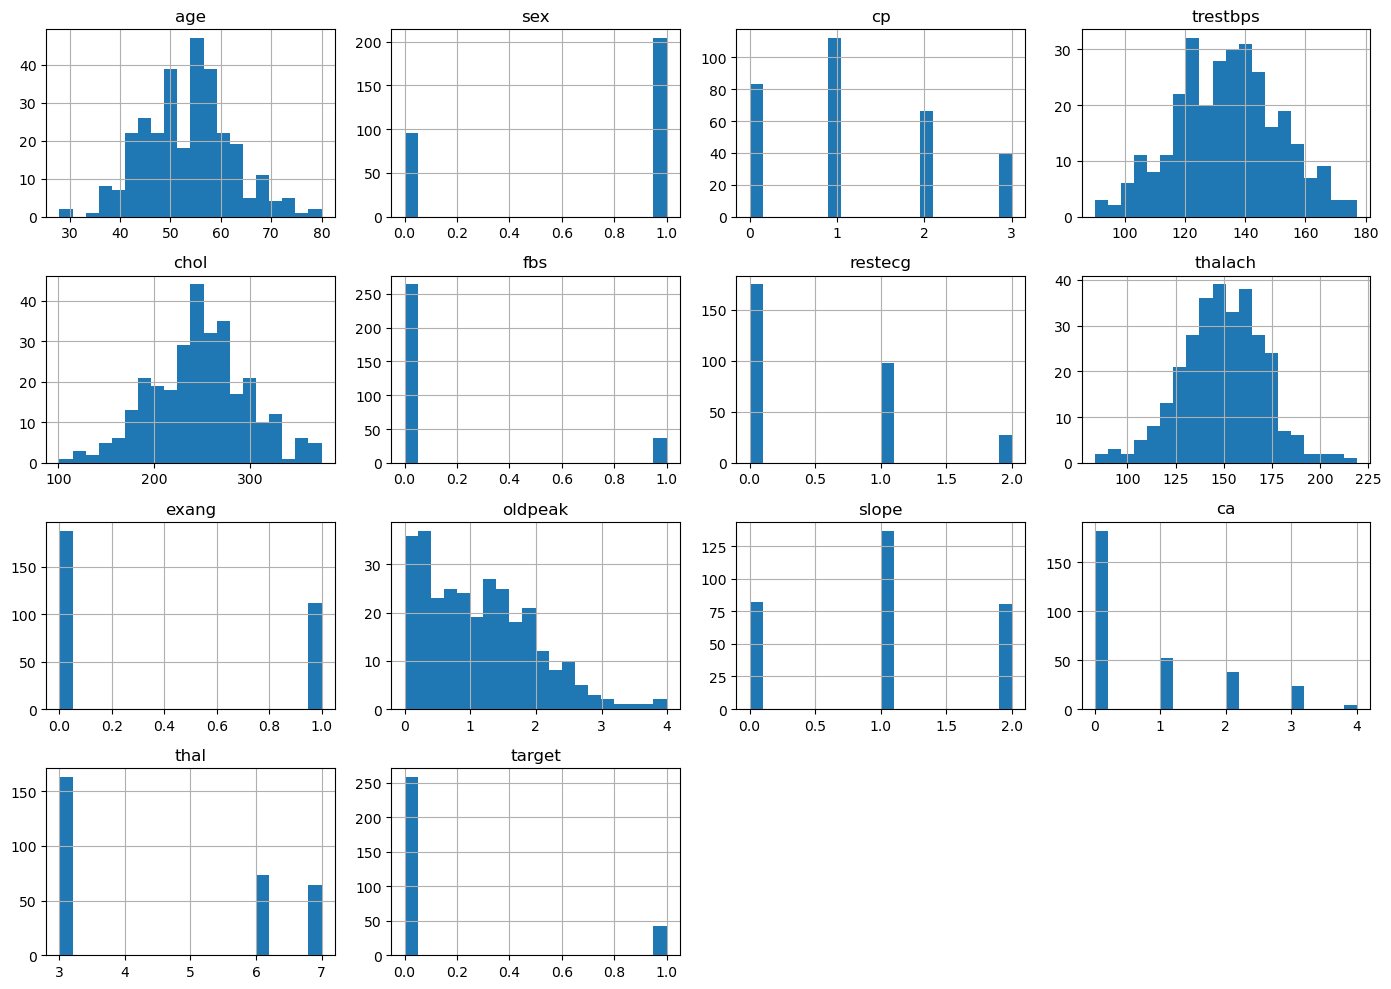

In [10]:
plt.figure(figsize=(12,8))
df.hist(bins=20, figsize=(14,10));
plt.tight_layout()

Text(0.5, 1.0, 'Boxplots - numerical features')

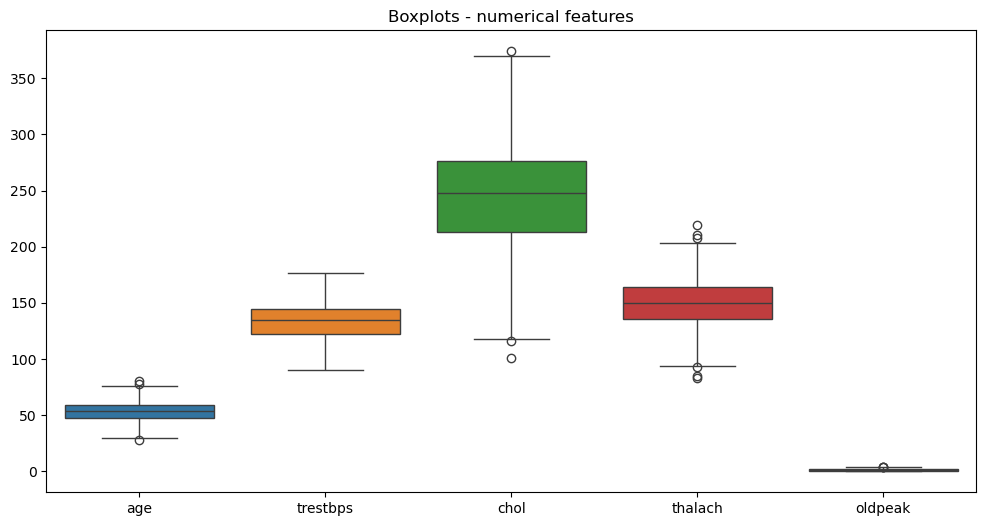

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['age','trestbps','chol','thalach','oldpeak']])
plt.title('Boxplots - numerical features')

Text(0.5, 1.0, 'Correlation matrix')

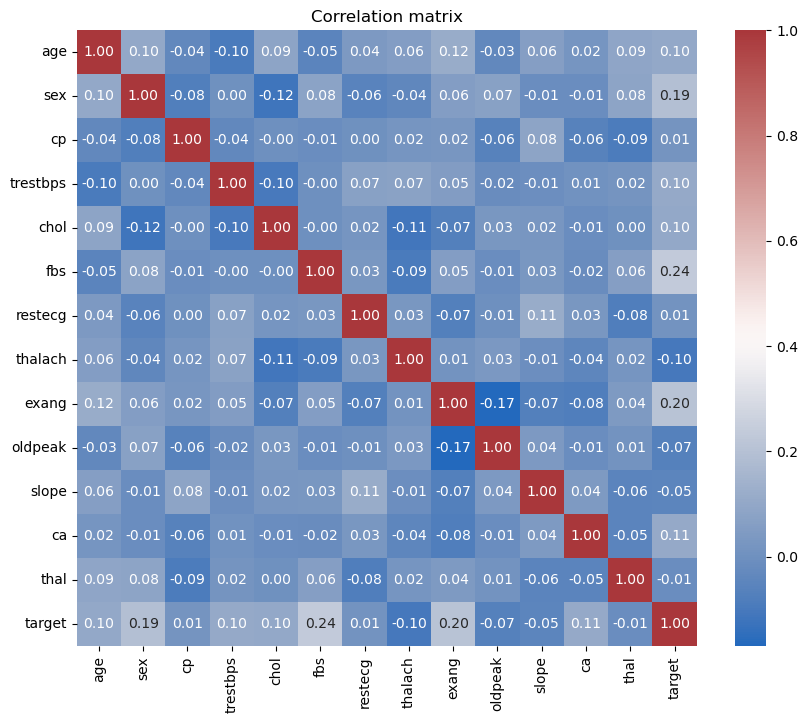

In [12]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation matrix')

In [13]:
for col in ['sex','cp','fbs','restecg','exang','slope','ca','thal']:
    df[col] = df[col].astype('category')

In [14]:
df_enc = pd.get_dummies(df, columns=['cp','restecg','slope','thal'], drop_first=True)

In [15]:
X = df_enc.drop('target', axis=1)
y = df_enc['target']

In [16]:
num_cols = ['age','trestbps','chol','thalach','oldpeak','ca']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


print('\nEncoded features shape:', X.shape)
print('Feature list:', X.columns.tolist())


Encoded features shape: (300, 18)
Feature list: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2', 'slope_1', 'slope_2', 'thal_6', 'thal_7']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (240, 18) Test size: (60, 18)


In [19]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]
print('\nBaseline Decision Tree performance:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_proba))
print('\nClassification report:')
print(classification_report(y_test, y_pred))


Baseline Decision Tree performance:
Accuracy: 0.8166666666666667
Precision: 0.2857142857142857
Recall: 0.25
F1-score: 0.26666666666666666
ROC-AUC: 0.5769230769230769

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        52
           1       0.29      0.25      0.27         8

    accuracy                           0.82        60
   macro avg       0.59      0.58      0.58        60
weighted avg       0.81      0.82      0.81        60



In [20]:
param_grid = {
'criterion': ['gini', 'entropy'],
'max_depth': [None, 3, 5, 7, 9],
'min_samples_split': [2, 5, 10, 20]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print('\nBest params:', grid.best_params_)
print('Best CV ROC-AUC:', grid.best_score_)


Best params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 20}
Best CV ROC-AUC: 0.6166279519938057


In [21]:
best_clf = grid.best_estimator_

In [22]:
y_pred_best = best_clf.predict(X_test)
y_proba_best = best_clf.predict_proba(X_test)[:,1]


print('\nTuned Decision Tree performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_best))
print('Precision:', precision_score(y_test, y_pred_best))
print('Recall:', recall_score(y_test, y_pred_best))
print('F1-score:', f1_score(y_test, y_pred_best))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_best))
print('\nClassification report:')
print(classification_report(y_test, y_pred_best))


Tuned Decision Tree performance:
Accuracy: 0.8333333333333334
Precision: 0.3333333333333333
Recall: 0.25
F1-score: 0.2857142857142857
ROC-AUC: 0.7271634615384615

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        52
           1       0.33      0.25      0.29         8

    accuracy                           0.83        60
   macro avg       0.61      0.59      0.60        60
weighted avg       0.81      0.83      0.82        60



Text(0.5, 1.0, 'Confusion Matrix')

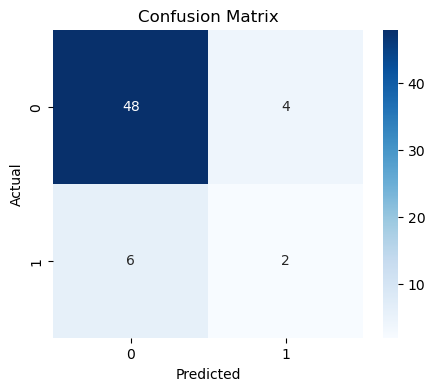

In [23]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Decision Tree (visualization)')

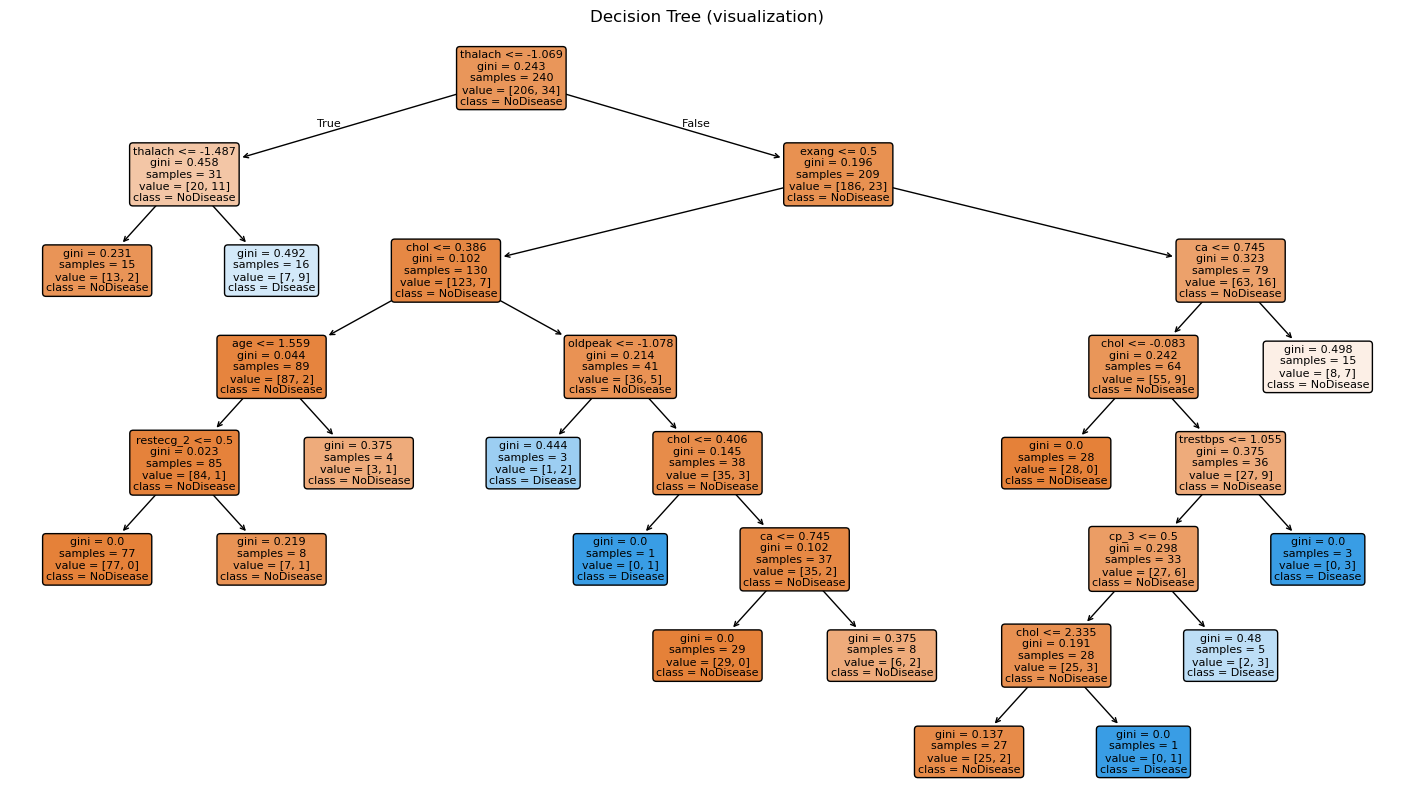

In [24]:
plt.figure(figsize=(18,10))
plot_tree(best_clf, feature_names=X.columns, class_names=['NoDisease','Disease'], filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree (visualization)')


Top feature importances:
thalach      0.235288
chol         0.228836
trestbps     0.142313
ca           0.130158
exang        0.083979
cp_3         0.079665
oldpeak      0.074246
age          0.016762
restecg_2    0.008754
sex          0.000000
cp_1         0.000000
fbs          0.000000
cp_2         0.000000
restecg_1    0.000000
slope_1      0.000000
dtype: float64


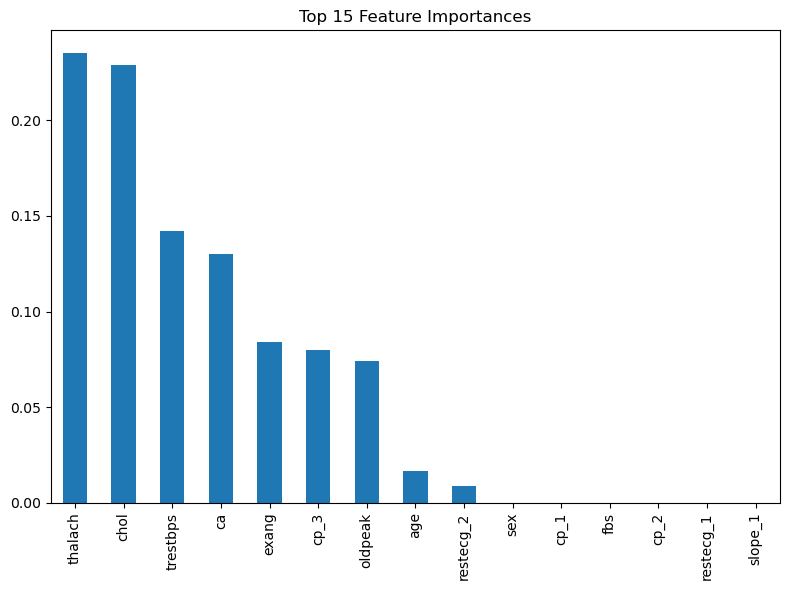

In [25]:
fi = pd.Series(best_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print('\nTop feature importances:')
print(fi.head(15))


plt.figure(figsize=(8,6))
fi.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances')
plt.tight_layout()

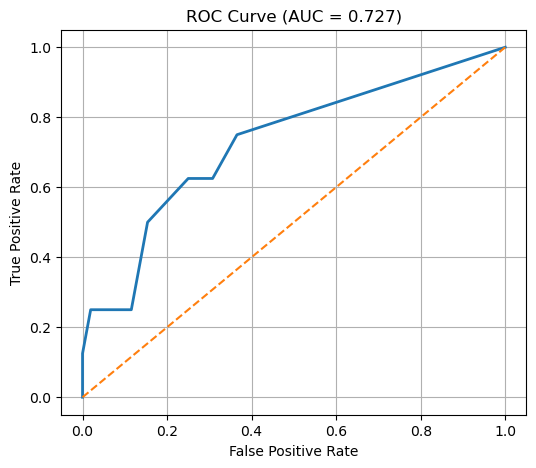

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.grid(True)